In [2]:
suppressPackageStartupMessages({
    library(dplyr)
    library(Seurat)
    library(patchwork)
    library(future)
    library(ggplot2)
    library(ggthemes)
    library(ggvenn)
    library(tidyr)
    library(pagoda2)
    library(tibble)
    library(cowplot)
    library(future)
    library(gplots)
    library(reshape2)
    library(EnhancedVolcano)
})
source("~/source/ggplot_theme.R")

# Loading and Preprocessing

In [2]:
aggr_run_name="cr_aggr-Colon_PS017-PS033"
data_root_dir="/datawaha_sfb/liz0f/Long-read-RNA-seq"
aggr_sample_dir=file.path(data_root_dir,"Illumina","cr_aggr",aggr_run_name)
aggr_csv_fp=file.path(aggr_sample_dir,"outs","aggregation.csv")
expr.data=Read10X(file.path(aggr_sample_dir,"outs","filtered_feature_bc_matrix"))
aggr_csv=read.csv(aggr_csv_fp)

In [3]:
expr <- CreateSeuratObject(counts = expr.data, project = aggr_run_name , min.cells = 1, min.features = 1)

In [4]:
# add mt expression to meta.data
expr = AddMetaData(expr,PercentageFeatureSet(expr, pattern = "^MT-"),col.name="percent.mt")
sample_code=as.integer(sapply(strsplit(colnames(expr.data),'-'),function(x) x[2]))
# add library_id and condition to meta.data
library_ids=aggr_csv[,"library_id"][sample_code]
condition=aggr_csv[,"condition"][sample_code]
expr=AddMetaData(expr,library_ids,col.name="library_id")
expr=AddMetaData(expr,condition,col.name="condition")

In [5]:
GetPatientId=function(x){
    x=sapply(x,function(x){strsplit(x,"_")[1]})
    x=sapply(x,function(x){s=strsplit(x[2],"-");return(unlist(s)[1])})
    return(x)
}
patient_id=GetPatientId(expr@meta.data[,"library_id"])
expr=AddMetaData(expr,patient_id,col.name="patient_id")

In [12]:
junction_table=read.csv(sprintf("%s/Illumina/cr_aggr/%s/outs/junction_table.tsv",data_root_dir,aggr_run_name),sep="\t")
mutation_table=read.csv(sprintf("%s/Illumina/cr_aggr/%s/outs/mutation_call.tsv",data_root_dir,aggr_run_name),sep="\t")
sample_name_map=1:nrow(aggr_csv)
names(sample_name_map)=aggr_csv[,"library_id"]
junction_table[,"cell_barcode"]=sapply(
    1:nrow(junction_table),
    function(i) sprintf("%s-%d",junction_table[i,"cell_barcode"],sample_name_map[junction_table[i,"sample_name"]])
)
mutation_table[,"cell_barcode"]=sapply(
    1:nrow(mutation_table),
    function(i) sprintf("%s-%d",mutation_table[i,"cell_barcode"],sample_name_map[mutation_table[i,"sample_name"]])
)
mutation_table[,"mutation_id"]=sapply(
    1:nrow(mutation_table),
    function(i) sprintf("%s_%s_%d_%s",mutation_table[i,"gene"],mutation_table[i,"chr"],mutation_table[i,"loc"],mutation_table[i,"op"])
)

In [15]:
total_count_table=expr@meta.data %>%
group_by(library_id) %>%
summarize(cell_count=n(),UMI_count=sum(nCount_RNA)) %>%
column_to_rownames("library_id")
# rownames(total_count_table)=pull(total_count_table,library_id)

In [24]:
# expr_filter=subset(
#     expr_info,
#     (library_id=="M-21-1308_PS017-N1" & nFeature_RNA>10 & nFeature_RNA < 1000 & nCount_RNA < 100000 & percent.mt<50) |
#     (library_id=="M-21-1309_PS017-T1" & nFeature_RNA>100 & nFeature_RNA < 7000 & nCount_RNA < 100000 & percent.mt<50) |
#     (library_id=="M-21-1310_PS017-N2" & nFeature_RNA>100 & nFeature_RNA < 1000 & nCount_RNA < 100000 & percent.mt<50) |
#     (library_id=="M-21-1311_PS017-T2" & nFeature_RNA>100 & nFeature_RNA < 7000 & nCount_RNA < 100000 & percent.mt<50) |
#     (library_id=="M-21-2099_PS018-N" & nFeature_RNA>100 & nFeature_RNA < 7000 & nCount_RNA < 100000 & percent.mt<50) |
#     (library_id=="M-21-2100_PS018-T" & nFeature_RNA>100 & nFeature_RNA < 7000 & nCount_RNA < 100000 & percent.mt<50) |
#     (library_id=="M-21-2101_PS028-N" & nFeature_RNA>100 & nFeature_RNA < 3000 & nCount_RNA < 100000 & percent.mt<50) |
#     (library_id=="M-21-2102_PS028-T" & nFeature_RNA>100 & nFeature_RNA < 3000 & nCount_RNA < 100000 & percent.mt<50) ,
#     features=rownames(expr_info)[!startsWith(rownames(expr_info),"MT-")]
# )

expr_filter=subset(expr_info,(nFeature_RNA>250)&(nCount_RNA>300)&(percent.mt<70),features=rownames(expr_info)[!startsWith(rownames(expr_info),"MT-")])
# expr_filter=subset(expr_info,features=rownames(expr)[!startsWith(rownames(expr),"MT-")])


In [1025]:
expr_filter@meta.data %>%
    group_by(library_id) %>%
    summarize(
        n_cells=n(),
        n_UMI_median=median(nCount_RNA),
        n_genes_median=median(nFeature_RNA),
        n_UMI_mean=mean(nCount_RNA),
        n_genes_mean=mean(nFeature_RNA)
    ) %>%
    write.csv("tmp_per_sample_statistics_filtered.csv")

In [ ]:

options(repr.plot.width=16, repr.plot.height=24)
VlnPlot(expr_filter ,features=c("nFeature_RNA","nCount_RNA","percent.mt"),ncol=1,group.by="library_id",pt.size=0)

In [ ]:
options(repr.plot.width=20, repr.plot.height=8)
cell_count_df=as.data.frame(table(expr_filter@meta.data["library_id"]))
colnames(cell_count_df)=c("library_id","cell_count")
ggplot(data=cell_count_df,mapping=aes(x=library_id,y=cell_count))+
geom_bar(mapping=aes(fill=library_id),stat="identity") +
my_theme +
theme(axis.text.x = element_text(angle = 70,vjust = 1,  hjust=1), aspect.ratio = 0.4)

# Dimentionality Reduction

In [25]:
pca=function(expr,normalize=F,find_variable=F){
    if(normalize){
        expr=NormalizeData(expr)
    }
    if(find_variable){
        expr <- FindVariableFeatures(expr, selection.method = "dispersion", nfeatures = 2000)
    }
    
    all.genes=rownames(expr)
    expr=ScaleData(expr,features=all.genes)
    expr=RunPCA(expr,features=VariableFeatures(expr))
    ep=ElbowPlot(expr)
    return(list(
        ep=ep,
        expr=expr
    ))
}


cluster=function(expr){
    expr <- FindNeighbors(expr, reduction="pca", dims = 1:30)
    expr <- FindClusters(expr, resolution = 0.99)
    
    expr <- RunUMAP(expr, reduction='pca', dims = 1:50)
    expr <- RunTSNE(expr, reduction='pca', dims = 1:50, check_duplicates=F)
    return(expr)
}

batch_correct_seurat_integration=function(expr,library_id_colname="library_id"){
    expr.library.list <- SplitObject(expr, split.by = library_id_colname)
    expr.library.list <- lapply(X = expr.library.list, FUN = function(x) {
        x <- NormalizeData(x)
        x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
    })
    features <- SelectIntegrationFeatures(
        object.list = expr.library.list
    )
    library_ids=unique(expr@meta.data[,library_id_colname])
    variable_features = SelectIntegrationFeatures(object.list = expr.library.list[library_ids])
    features_all=union(features,variable_features)
    print(length(features_all))
    expr.anchors <- FindIntegrationAnchors(
        object.list = expr.library.list, 
        anchor.features = features_all
    )
    expr.combined <- IntegrateData(anchorset = expr.anchors)
    return(expr.combined)
}


batch_correct_pagoda2=function(expr,batch_field="library_id"){
    DefaultAssay(expr)="RNA"
    expr=NormalizeData(expr)
    counts=GetAssayData(expr,assay="RNA",slot="counts")
    pg <- Pagoda2$new(counts, log.scale=TRUE, n.cores=1, min.transcripts.per.cell=0)
    batch_data=expr@meta.data[,batch_field]
    names(batch_data)=colnames(counts)
    pg$batch = batch_data
    pg$setCountMatrix(counts, min.cells.per.gene=0, trim=0, 
                         min.transcripts.per.cell=0, lib.sizes=NULL,
                         log.scale=T, keep.genes=NULL)
    pg_assay=CreateAssayObject(data=t(pg$counts))
    pg_assay@counts=counts
    expr[["pagoda2"]]=pg_assay
    DefaultAssay(expr)="pagoda2"
    if(length(expr$pagoda2@var.features)==0){
        expr <- FindVariableFeatures(expr, selection.method = "vst", nfeatures = 2000)
    }
    return(expr)
}


filter_rename_library=function(expr){
    library_name_map=c(
        "M-21-1308_PS017-N1"="N_combined",
        "M-21-1309_PS017-T1"="M-21-1309_PS017-T1",
        "M-21-1310_PS017-N2"="N_combined",
        "M-21-1311_PS017-T2"="M-21-1311_PS017-T2",
        "M-21-2099_PS018-N"="M-21-2099_PS018-N",
        "M-21-2100_PS018-T"="M-21-2100_PS018-T",
        "M-21-2089_PS019-N"="N_combined",
        "M-21-2090_PS021-N"="M-21-2090_PS021-N",
        "M-21-2091_PS021-T"="T_combined",
        "M-21-2098_PS025-T"="M-21-2098_PS025-T",
        "M-21-2095_PS026-N2"="M-21-2095_PS026-N2",
        "M-21-2096_PS026-T"="T_combined",
        "M-21-2097_PS027-N"="M-21-2097_PS027-N",
        "M-21-2101_PS028-N"="N_combined",
        "M-21-2102_PS028-T"="T_combined",
        "M-21-2087_PS029-N"="N_combined",
        "M-21-2088_PS029-T"="T_combined",
        "M-21-2092_PS031-N"="N_combined",
        "M-21-2395_PS032-N2"="M-21-2395_PS032-N2",
        "M-21-2396_PS032-T"="M-21-2396_PS032-T",
        "M-21-2397_PS033-N"="M-21-2397_PS033-N",
        "M-21-2398_PS033-T"="M-21-2398_PS033-T"
    )

    expr@meta.data[,"library_id_merged"]=sapply(expr@meta.data[,"library_id"],function(x){library_name_map[x]})
    return(subset(expr))
}
rename_patient_id=function(expr){
    old_patient_ids=c(
        "PS029", "PS031" 
    )
    new_patient_ids=c("PS029_PS031","PS029_PS031")
    names(new_patient_ids)=old_patient_ids
    expr@meta.data[,"patient_id_merged"]=sapply(expr@meta.data[,"patient_id"],function(x){
      if(x %in% names(new_patient_ids)){
          return(new_patient_ids[x])
      }else{
          return(x)
      }
    })
    return(expr)
}

In [49]:
seurat_list_preprocess=function(expr.list, nfeatures=2000, features=NULL){
    for (i in 1:length(expr.list)) {
        expr.list[[i]] <- NormalizeData(expr.list[[i]], verbose = FALSE)
        if(is.null(features)){
            expr.list[[i]] = FindVariableFeatures(
                expr.list[[i]],
                selection.method = "vst",
                nfeatures = nfeatures,
                assay="RNA"
            )
        } else {
            VariableFeatures(expr.list[[i]])=features
        }
        
    }
    return(expr.list)
}
seurat_list_integration=function(expr.list,anchor.features){

    expr.anchors <- FindIntegrationAnchors(object.list = expr.list, dims = 1:30, anchor.features=anchor.features)
    expr.integrated <- IntegrateData(anchorset = expr.anchors, dims = 1:30)
    DefaultAssay(expr.integrated)="integrated"
    return(expr.integrated)
}

get_transformed_assay=function(expr.ref,expr.query.list,integration_features){
    DefaultAssay(expr.ref) <- "integrated"
    predictions.list=list()
    for(i in 1:length(expr.query.list)){
        anchors <- FindTransferAnchors(
            reference = expr.ref, 
            query = expr.query.list[[i]], dims = 1:30,
            anchor.features = integration_features
        )
        predictions <- TransferData(
            anchorset = anchors, refdata = GetAssayData(expr.ref[["integrated"]]), dims = 1:30
        ) 
        predictions.list[[i]]=predictions
    }
    
    return(predictions.list)
}

concatenate_transformed_seurat_object=function(reference,query_original_list,query_transformed_assay_list){
    DefaultAssay(reference)="integrated"
    
    query_transformed_list=query_original_list
    for(i in 1:length(query_transformed_list)){
        query_transformed_list[[i]][["integrated"]]=query_transformed_assay_list[[i]]
        DefaultAssay(query_transformed_list[[i]])="integrated"
    }
    
    
    concatenated=merge(reference,query_transformed_list)
    DefaultAssay(concatenated)="integrated"
    VariableFeatures(concatenated)=rownames(concatenated)
    return(concatenated)
}

batch_correct_seurat_reference_transform=function(
    expr,
    ref_normal_batch_ids,
    ref_tumor_batch_ids,
    query_batch_ids,
    batch_field="library_id"
){
    nfeatures=dim(expr)[1]
    all_features=rownames(expr)
    
    expr.list=SplitObject(expr,split.by=batch_field)
    expr.list.ref_normal=expr.list[ref_normal_batch_ids]
    expr.list.ref_tumor=expr.list[ref_tumor_batch_ids]
    
    expr.list.ref_normal=seurat_list_preprocess(expr.list.ref_normal, features = all_features)
    expr.list.ref_tumor=seurat_list_preprocess(expr.list.ref_tumor, features = all_features)

    
    if(length(query_batch_ids)>0){
        expr.list.query=expr.list[query_batch_ids]
        expr.list.query=seurat_list_preprocess(expr.list.query,nfeatures=nfeatures)
    }
    
    expr.ref_normal=seurat_list_integration(expr.list.ref_normal,all_features)
    expr.ref_tumor=seurat_list_integration(expr.list.ref_tumor,all_features)
    expr.ref=merge(expr.ref_normal,expr.ref_tumor)
    if(length(query_batch_ids)>0){
        predictions.list=get_transformed_assay(expr.ref,expr.list.query,integration_features)
        expr=concatenate_transformed_seurat_object(expr.ref,expr.list.query,predictions.list)
    } else{
        expr = expr.ref
    }
    return(expr)
}

batch_correct_seurat_reference_transform_TN_together=function(
    expr,
    batch_field="library_id"
){
    nfeatures=dim(expr)[1]
    expr.list=SplitObject(expr,split.by=batch_field)
    expr.list = seurat_list_preprocess(expr.list, nfeatures = nfeatures)

    integration_features <- SelectIntegrationFeatures(
        object.list = expr.list, 
        nfeatures = nfeatures
    )

    
    expr.ref=seurat_list_integration(expr.list,integration_features)
    
    return(expr.ref)
}


In [50]:
old_bc=function(expr_filter){
    expr_rename_library=filter_rename_library(expr_filter)
    expr_rename_patient_id=rename_patient_id(expr_rename_library)
    # expr_bc=batch_correct(expr_rename_patient_id,library_id_colname = "patient_id_merged")
    expr_bc=batch_correct_pagoda2(expr_rename_patient_id,batch_field = "patient_id_merged")
    # expr_bc=expr_filter
}

if(FALSE){
    expr_rename_library=filter_rename_library(expr_filter)
    ref_normal_batch_ids=c("M-21-2090_PS021-N","M-21-2095_PS026-N2")
    # ref_normal_batch_ids=c("M-21-2097_PS027-N","M-21-2099_PS018-N")
    ref_tumor_batch_ids=c("M-21-2100_PS018-T","M-21-1309_PS017-T1")
    all_library_ids=unique(expr_rename_library$library_id_merged)
    query_batch_ids=all_library_ids[
        (!all_library_ids %in% ref_normal_batch_ids)&(!all_library_ids %in% ref_tumor_batch_ids)
    ]

    expr_bc=batch_correct_seurat_reference_transform(
        expr_rename_library,
        ref_normal_batch_ids,
        ref_tumor_batch_ids,
        query_batch_ids,
        batch_field="library_id_merged"
    )
}

if(TRUE){
    expr_rename_library=filter_rename_library(expr_filter)
    ref_normal_batch_ids=c(
        'M-21-2090_PS021-N',
        'M-21-2095_PS026-N2',
        'M-21-2097_PS027-N',
        'M-21-2099_PS018-N',
        'M-21-2395_PS032-N2',
        'M-21-2397_PS033-N',
        'N_combined'
    )
    ref_tumor_batch_ids=c(
        'M-21-1309_PS017-T1',
        'M-21-1311_PS017-T2',
        'M-21-2098_PS025-T',
        'M-21-2100_PS018-T',
        'M-21-2396_PS032-T',
        'M-21-2398_PS033-T',
        'T_combined'
    )
    query_batch_ids=c()
    
    expr_bc=batch_correct_seurat_reference_transform(
        expr_rename_library,
        ref_normal_batch_ids,
        ref_tumor_batch_ids,
        query_batch_ids,
        batch_field="library_id_merged"
    )
}

if(FALSE){
    expr_rename_library=filter_rename_library(expr_filter)
    ref_normal_batch_ids=c(
        'M-21-2090_PS021-N',
        'M-21-2095_PS026-N2',
        'M-21-2097_PS027-N',
        'M-21-2099_PS018-N',
        'M-21-2395_PS032-N2',
        'M-21-2397_PS033-N',
        'N_combined'
    )
    ref_tumor_batch_ids=c(
        'M-21-1309_PS017-T1',
        'M-21-1311_PS017-T2',
        'M-21-2098_PS025-T',
        'M-21-2100_PS018-T',
        'M-21-2396_PS032-T',
        'M-21-2398_PS033-T',
        'T_combined'
    )
    query_batch_ids=c()
    
    expr_bc=batch_correct_seurat_reference_transform_TN_together(
        expr_rename_library,
        batch_field="library_id_merged"
    )
}

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8152 anchors

Filtering anchors

	Retained 2618 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3512 anchors

Filtering anchors

	Retained 2108 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3076 anchors

Filtering anchors

	Retained 2466 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2043 anchors

Filtering anchors

	Retained 1555 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1968 anchors

Filtering anchors

	Retained 1712 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1789 anchors

Filtering anchors

	Retained 1533 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1342 anchors

Filtering anchors

	Retained 1204 an

In [56]:
# batch corrected
ret=pca(expr_bc,normalize=F,find_variable=T)
# non-batch corrected
# ret=pca(expr_bc,normalize=T,find_variable=T)
expr_pca=ret[["expr"]]
ep=ret[["ep"]]

Centering and scaling data matrix

PC_ 1 
Positive:  RPS18, RPL18A, RPS19, RPS2, RPS5, RPS15, RPL8, RPL19, RPL13, FTL 
	   RPL18, RPL30, RPL10, RPL29, RPS8, RPS16, RPS12, RPL21, RPS9, RPL28 
	   RPS4X, RPS14, RPL3, RPL13A, RPL23A, RPS11, RPS3, RPL32, RPL14, RPS7 
Negative:  MTRNR2L12, PIGR, ZG16, MTRNR2L8, MUC2, FCGBP, CA1, CLCA1, CA2, HBB 
	   ITGA1, GOLGA8A, SLC26A3, HBA2, SPN, SLC26A2, CEACAM7, GUCA2A, SGK1, INPP5D 
	   SAMD9, STAT4, JAML, ITGAL, SLC25A37, SLFN12L, CLCA4, SLC4A4, NPIPB5, FAM214A 
PC_ 2 
Positive:  PHGR1, LGALS4, PIGR, EPCAM, KRT8, TFF3, MUC12, AGR2, CD24, C15orf48 
	   TSPAN8, CEACAM5, IFI27, KRT19, LGALS3, ZG16, ELF3, MUC2, S100A6, FCGBP 
	   SLC26A2, ITM2C, TSPAN1, FABP1, CA1, KRT18, CKB, TPM1, CLCA1, MTRNR2L12 
Negative:  CXCR4, PTPRC, SRGN, RGS1, TSC22D3, IL7R, SMAP2, CD52, CD3D, BTG1 
	   CYTIP, TNFAIP3, VIM, SLA, LCP1, TRBC2, CD53, CORO1A, STK17B, ETS1 
	   CD2, LAPTM5, HCST, TRAC, CD48, PRDM1, CD69, CD3G, KLRB1, FKBP5 
PC_ 3 
Positive:  CEACAM6, AREG, KRT20, 

In [57]:
expr_cluster=cluster(expr_pca)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19015
Number of edges: 908534

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8783
Number of communities: 31
Elapsed time: 2 seconds


18:34:14 UMAP embedding parameters a = 0.9922 b = 1.112

18:34:14 Read 19015 rows and found 50 numeric columns

18:34:14 Using Annoy for neighbor search, n_neighbors = 30

18:34:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:34:16 Writing NN index file to temp file /tmp/RtmpLPhRCF/file274b7fd8693

18:34:16 Searching Annoy index using 1 thread, search_k = 3000

18:34:21 Annoy recall = 100%

18:34:21 Commencing smooth kNN distance calibration using 1 thread

18:34:22 Initializing from normalized Laplacian + noise

18:34:23 Commencing optimization for 200 epochs, with 904974 positive edges

18:34:31 Optimization finished



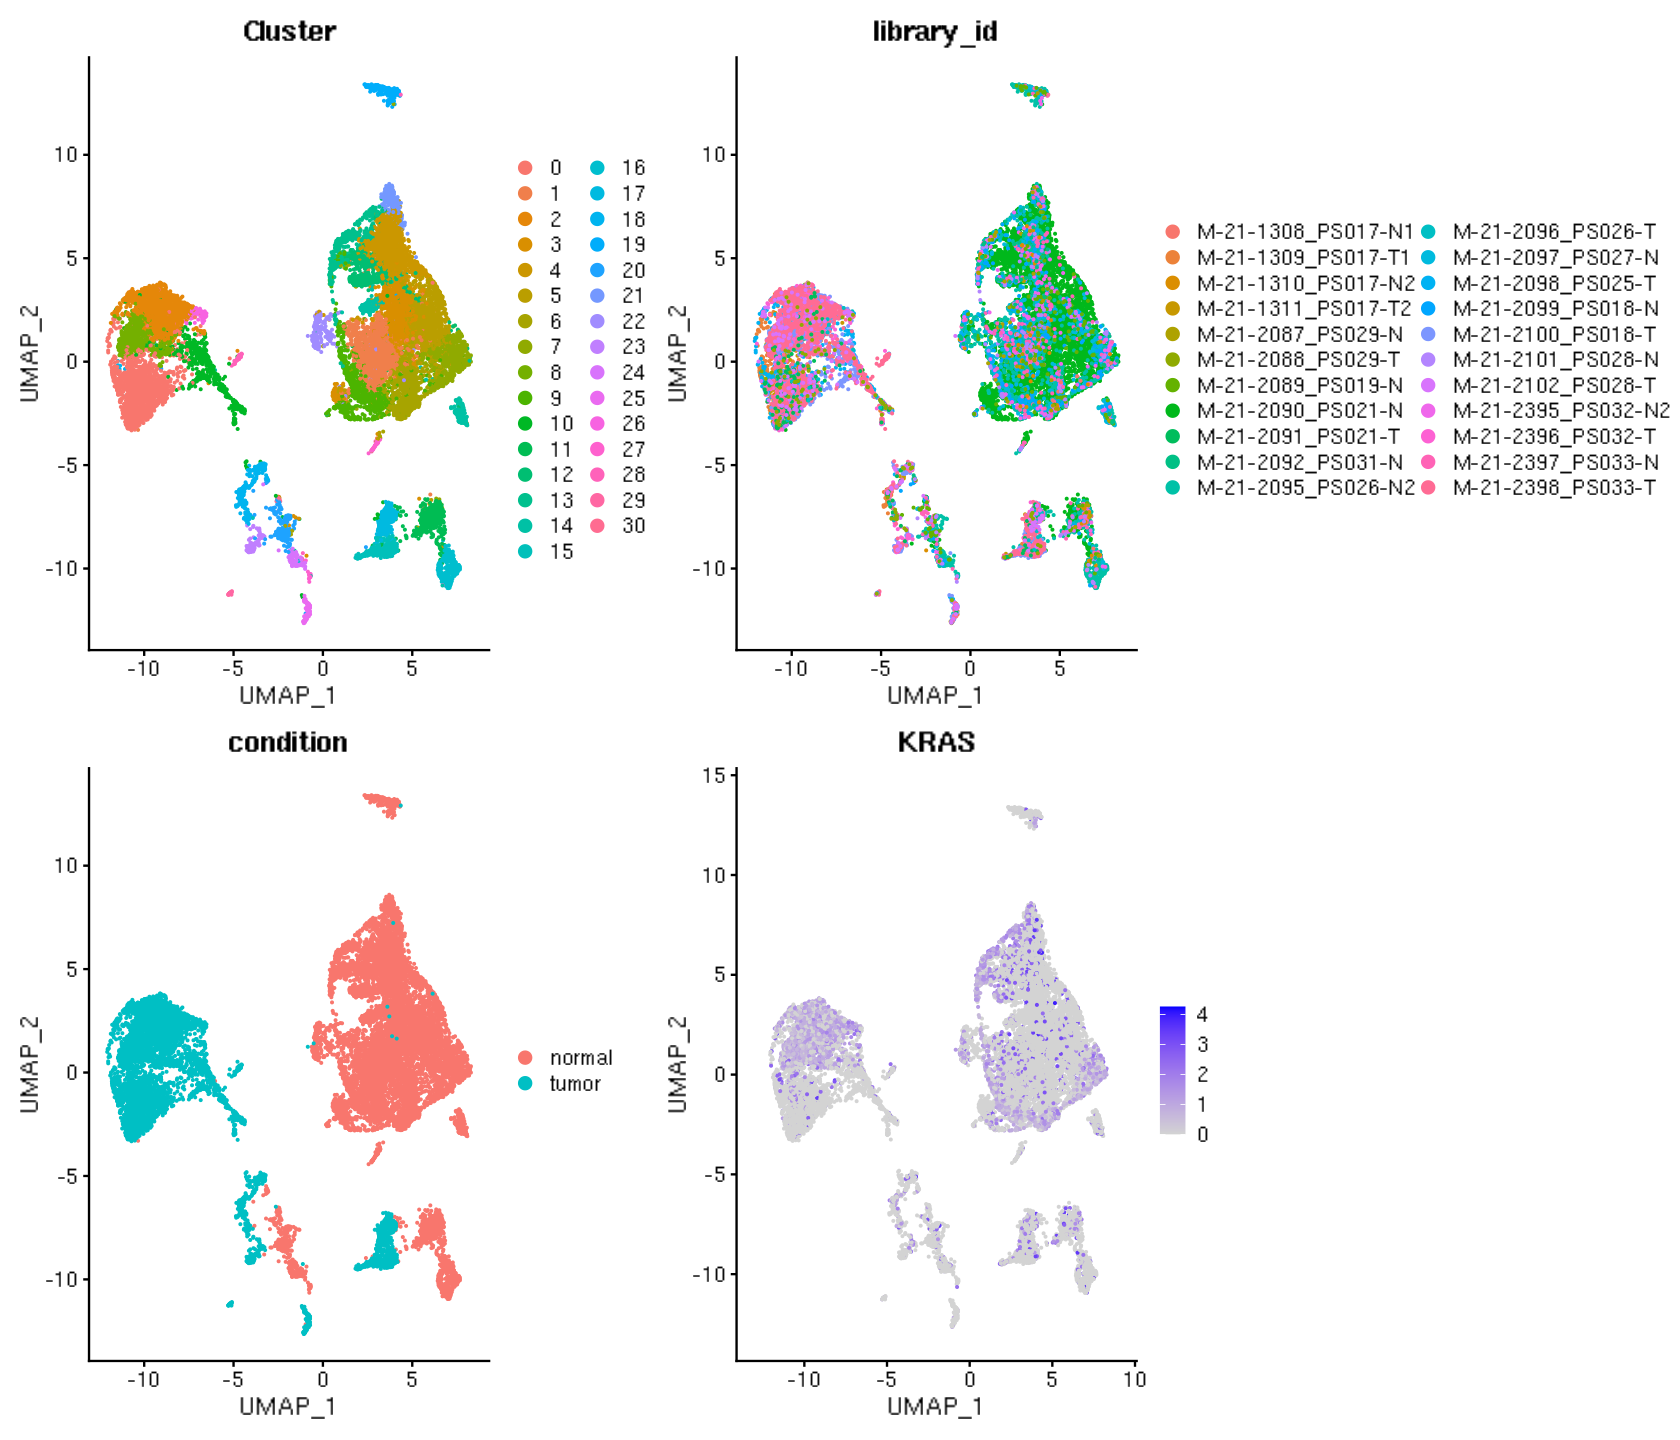

In [58]:
options(repr.plot.width=14, repr.plot.height=12)
source("~/source/ggplot_theme.R")
p1=DimPlot(expr_cluster, reduction = "umap", group.by="integrated_snn_res.0.99") + ggtitle("Cluster") +theme(plot.title = element_text(hjust = 0.5))
p2=DimPlot(expr_cluster, reduction = "umap", group.by="library_id")
p3=DimPlot(expr_cluster, reduction = "umap", group.by="condition")
DefaultAssay(expr_cluster) <- "RNA"
p4=FeaturePlot(
    expr_cluster, 
    features="KRAS",
    reduction = "umap"
) 
p1+p2+p3+p4+plot_layout(ncol=2)

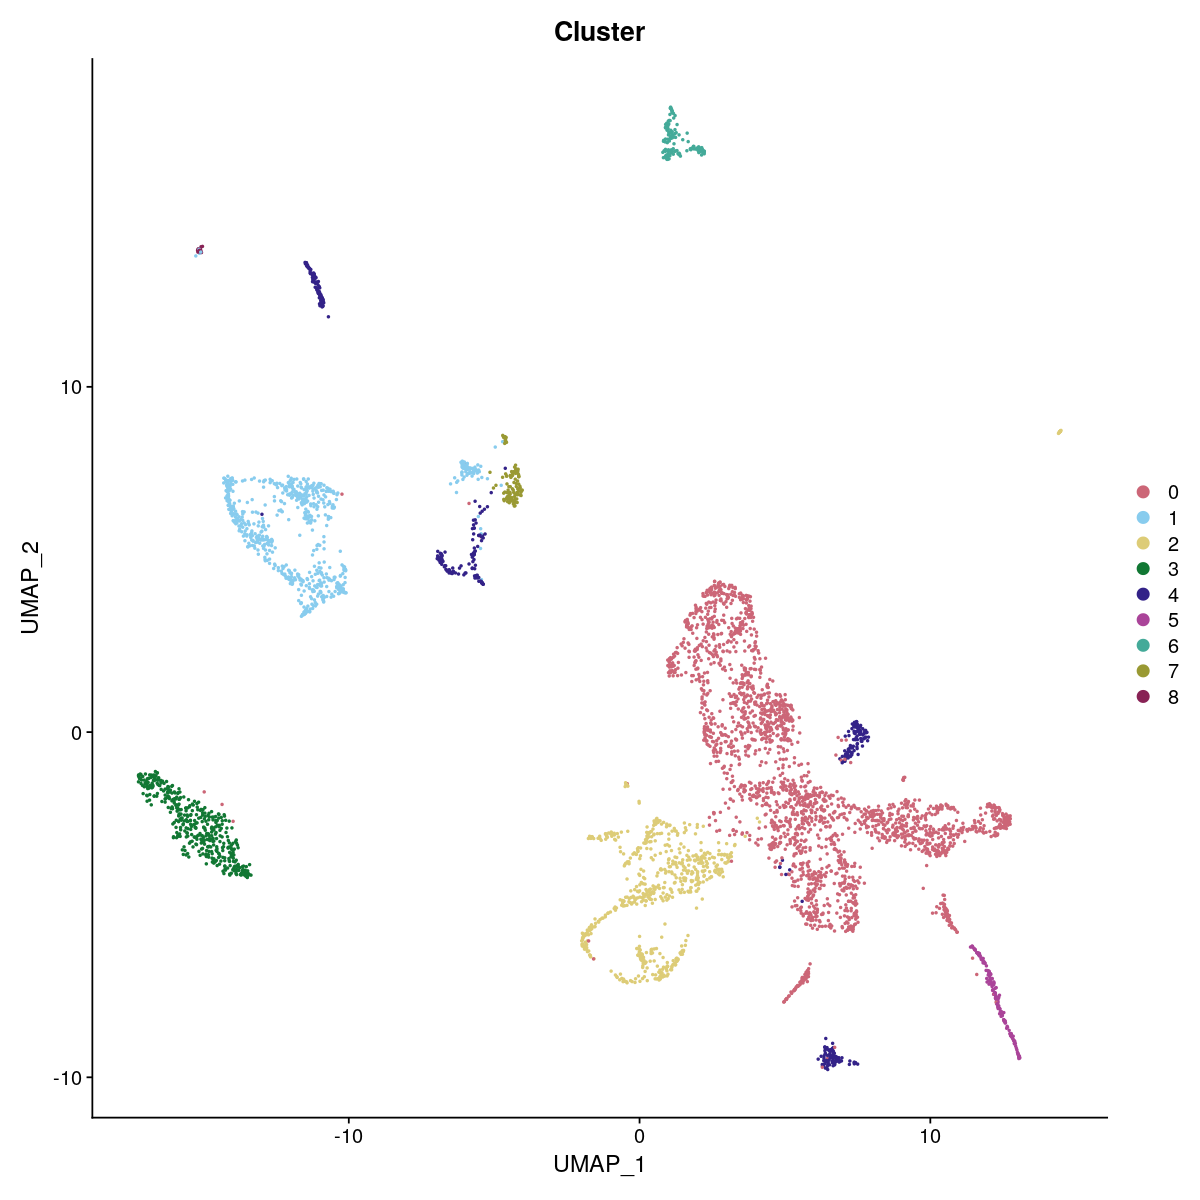

In [79]:
options(repr.plot.width=10, repr.plot.height=10)
source("~/source/ggplot_theme.R")
DimPlot(expr_cluster, reduction = "umap",cols=friendly_cols) + ggtitle("Cluster") +theme(plot.title = element_text(hjust = 0.5))

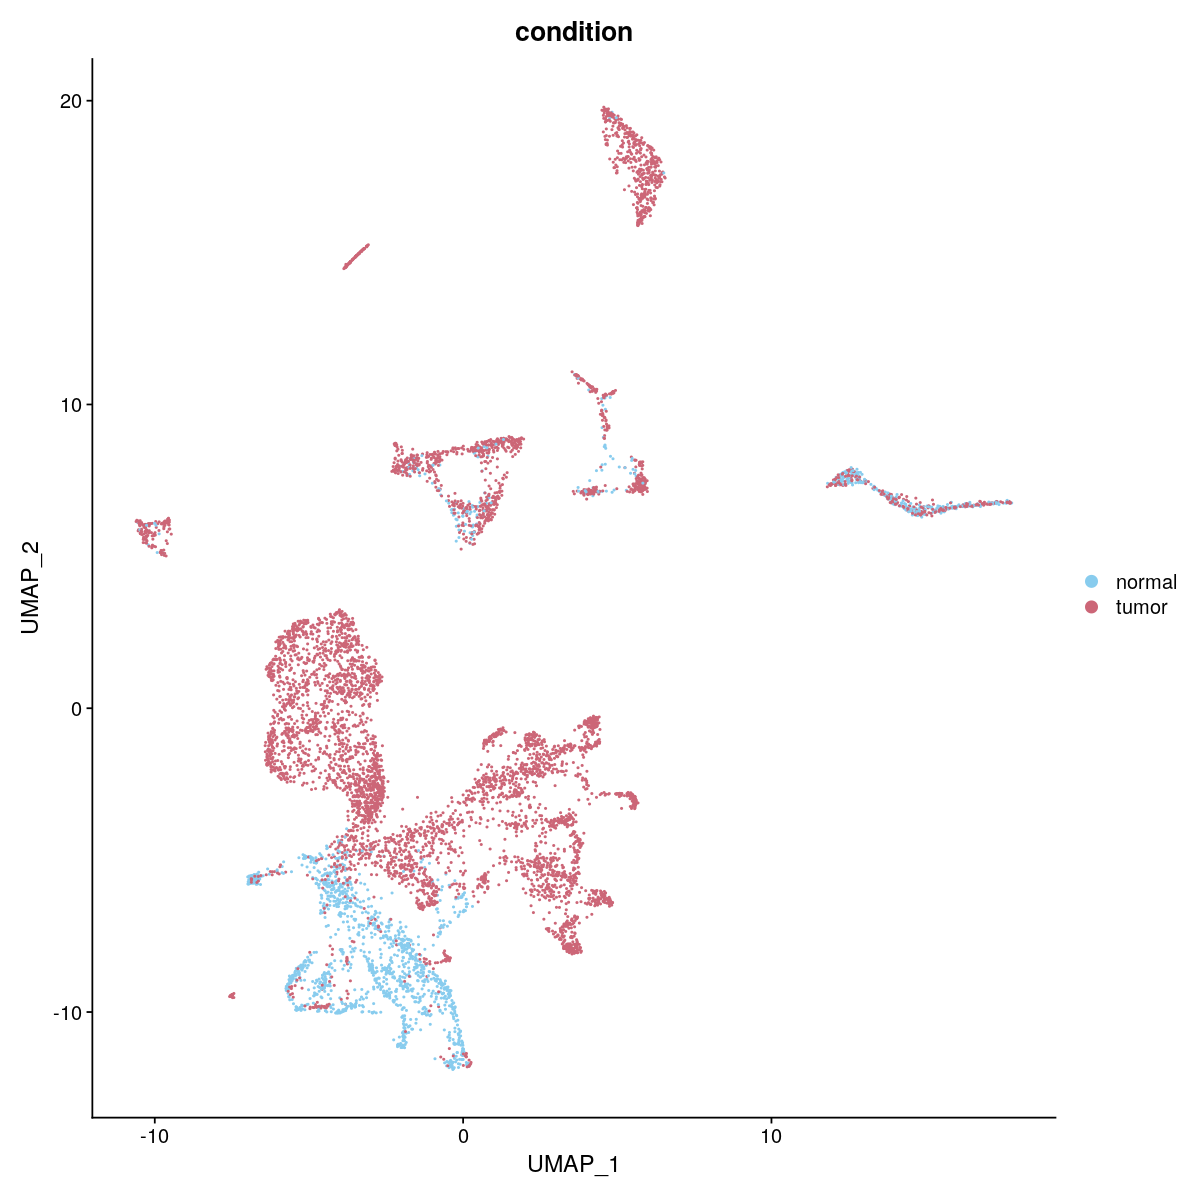

In [17]:
DimPlot(expr_cluster, reduction = "umap",cols=c(friendly_cols[2],friendly_cols[1]),group.by="condition")

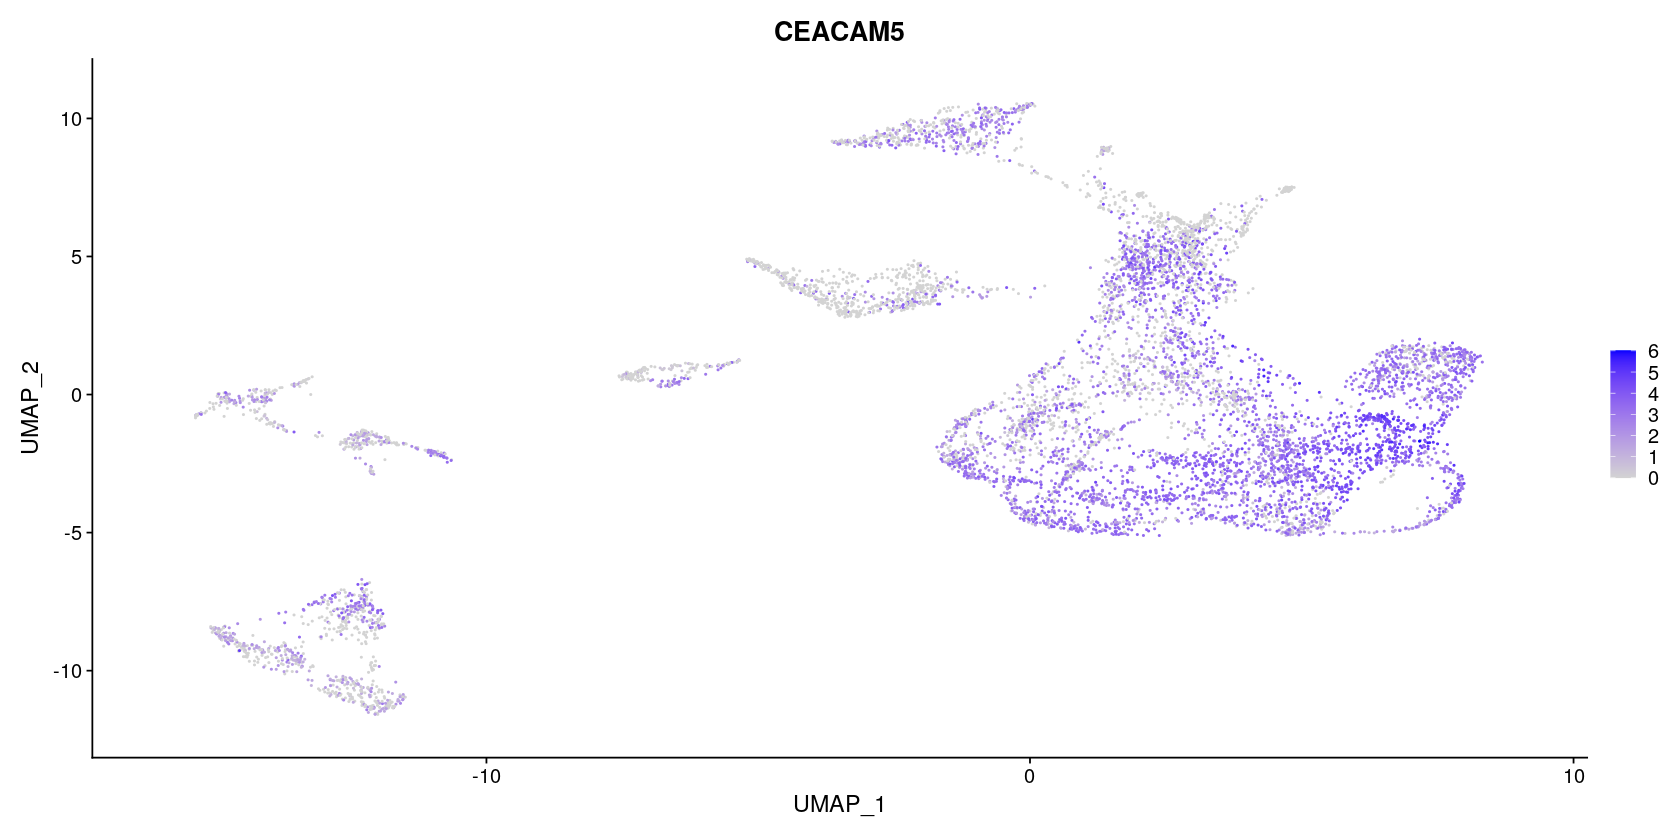

In [74]:
DefaultAssay(expr_cluster) <- "RNA"
FeaturePlot(
    expr_cluster, 
    features="CEACAM5",
    reduction = "umap"
) 

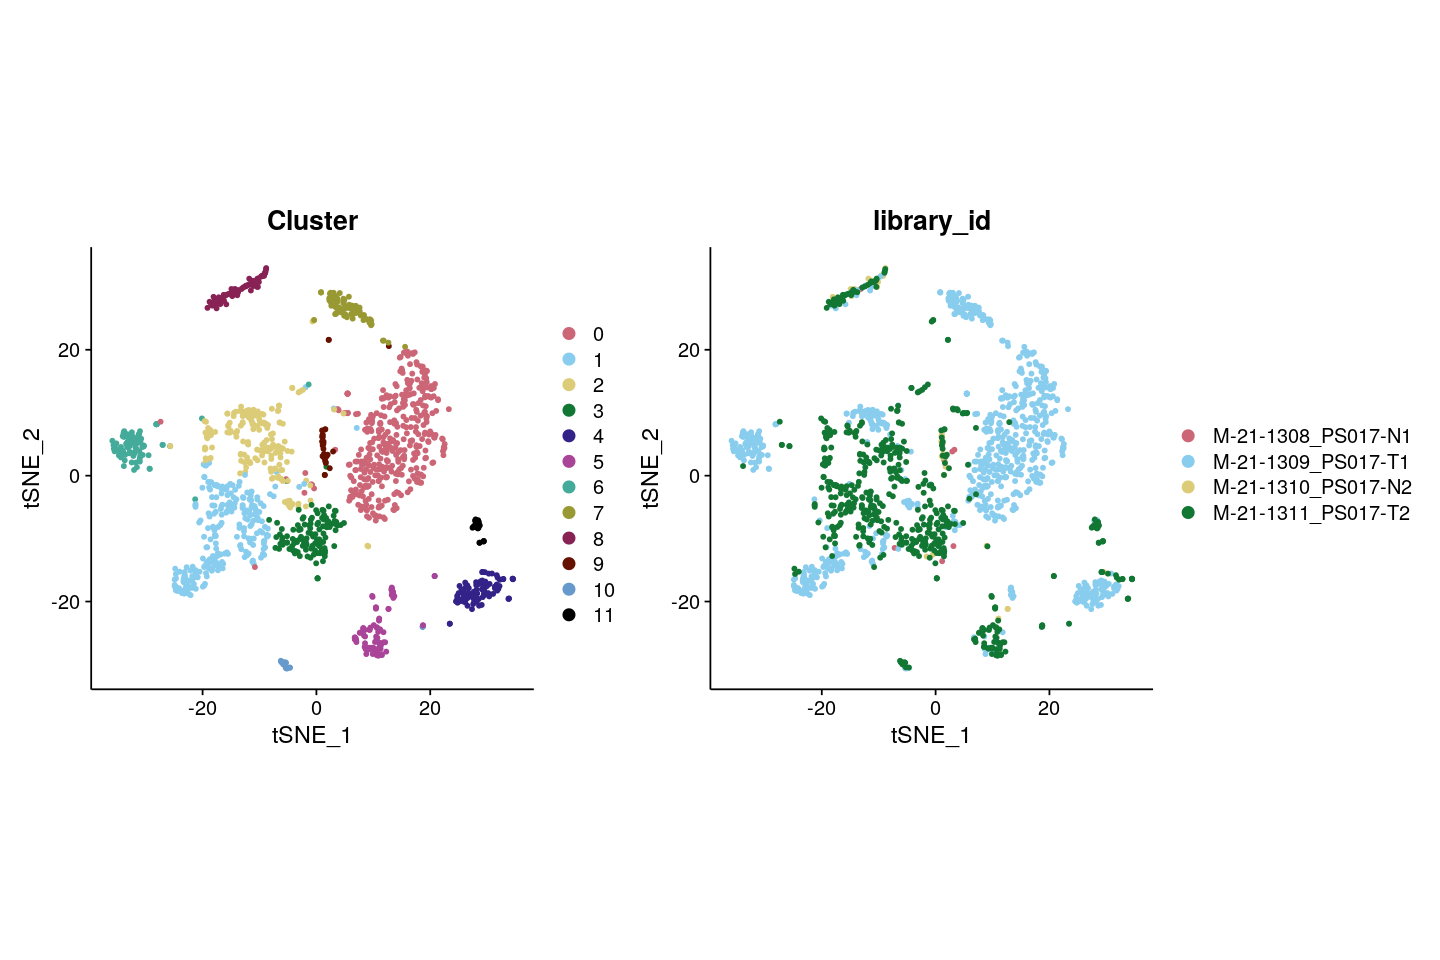

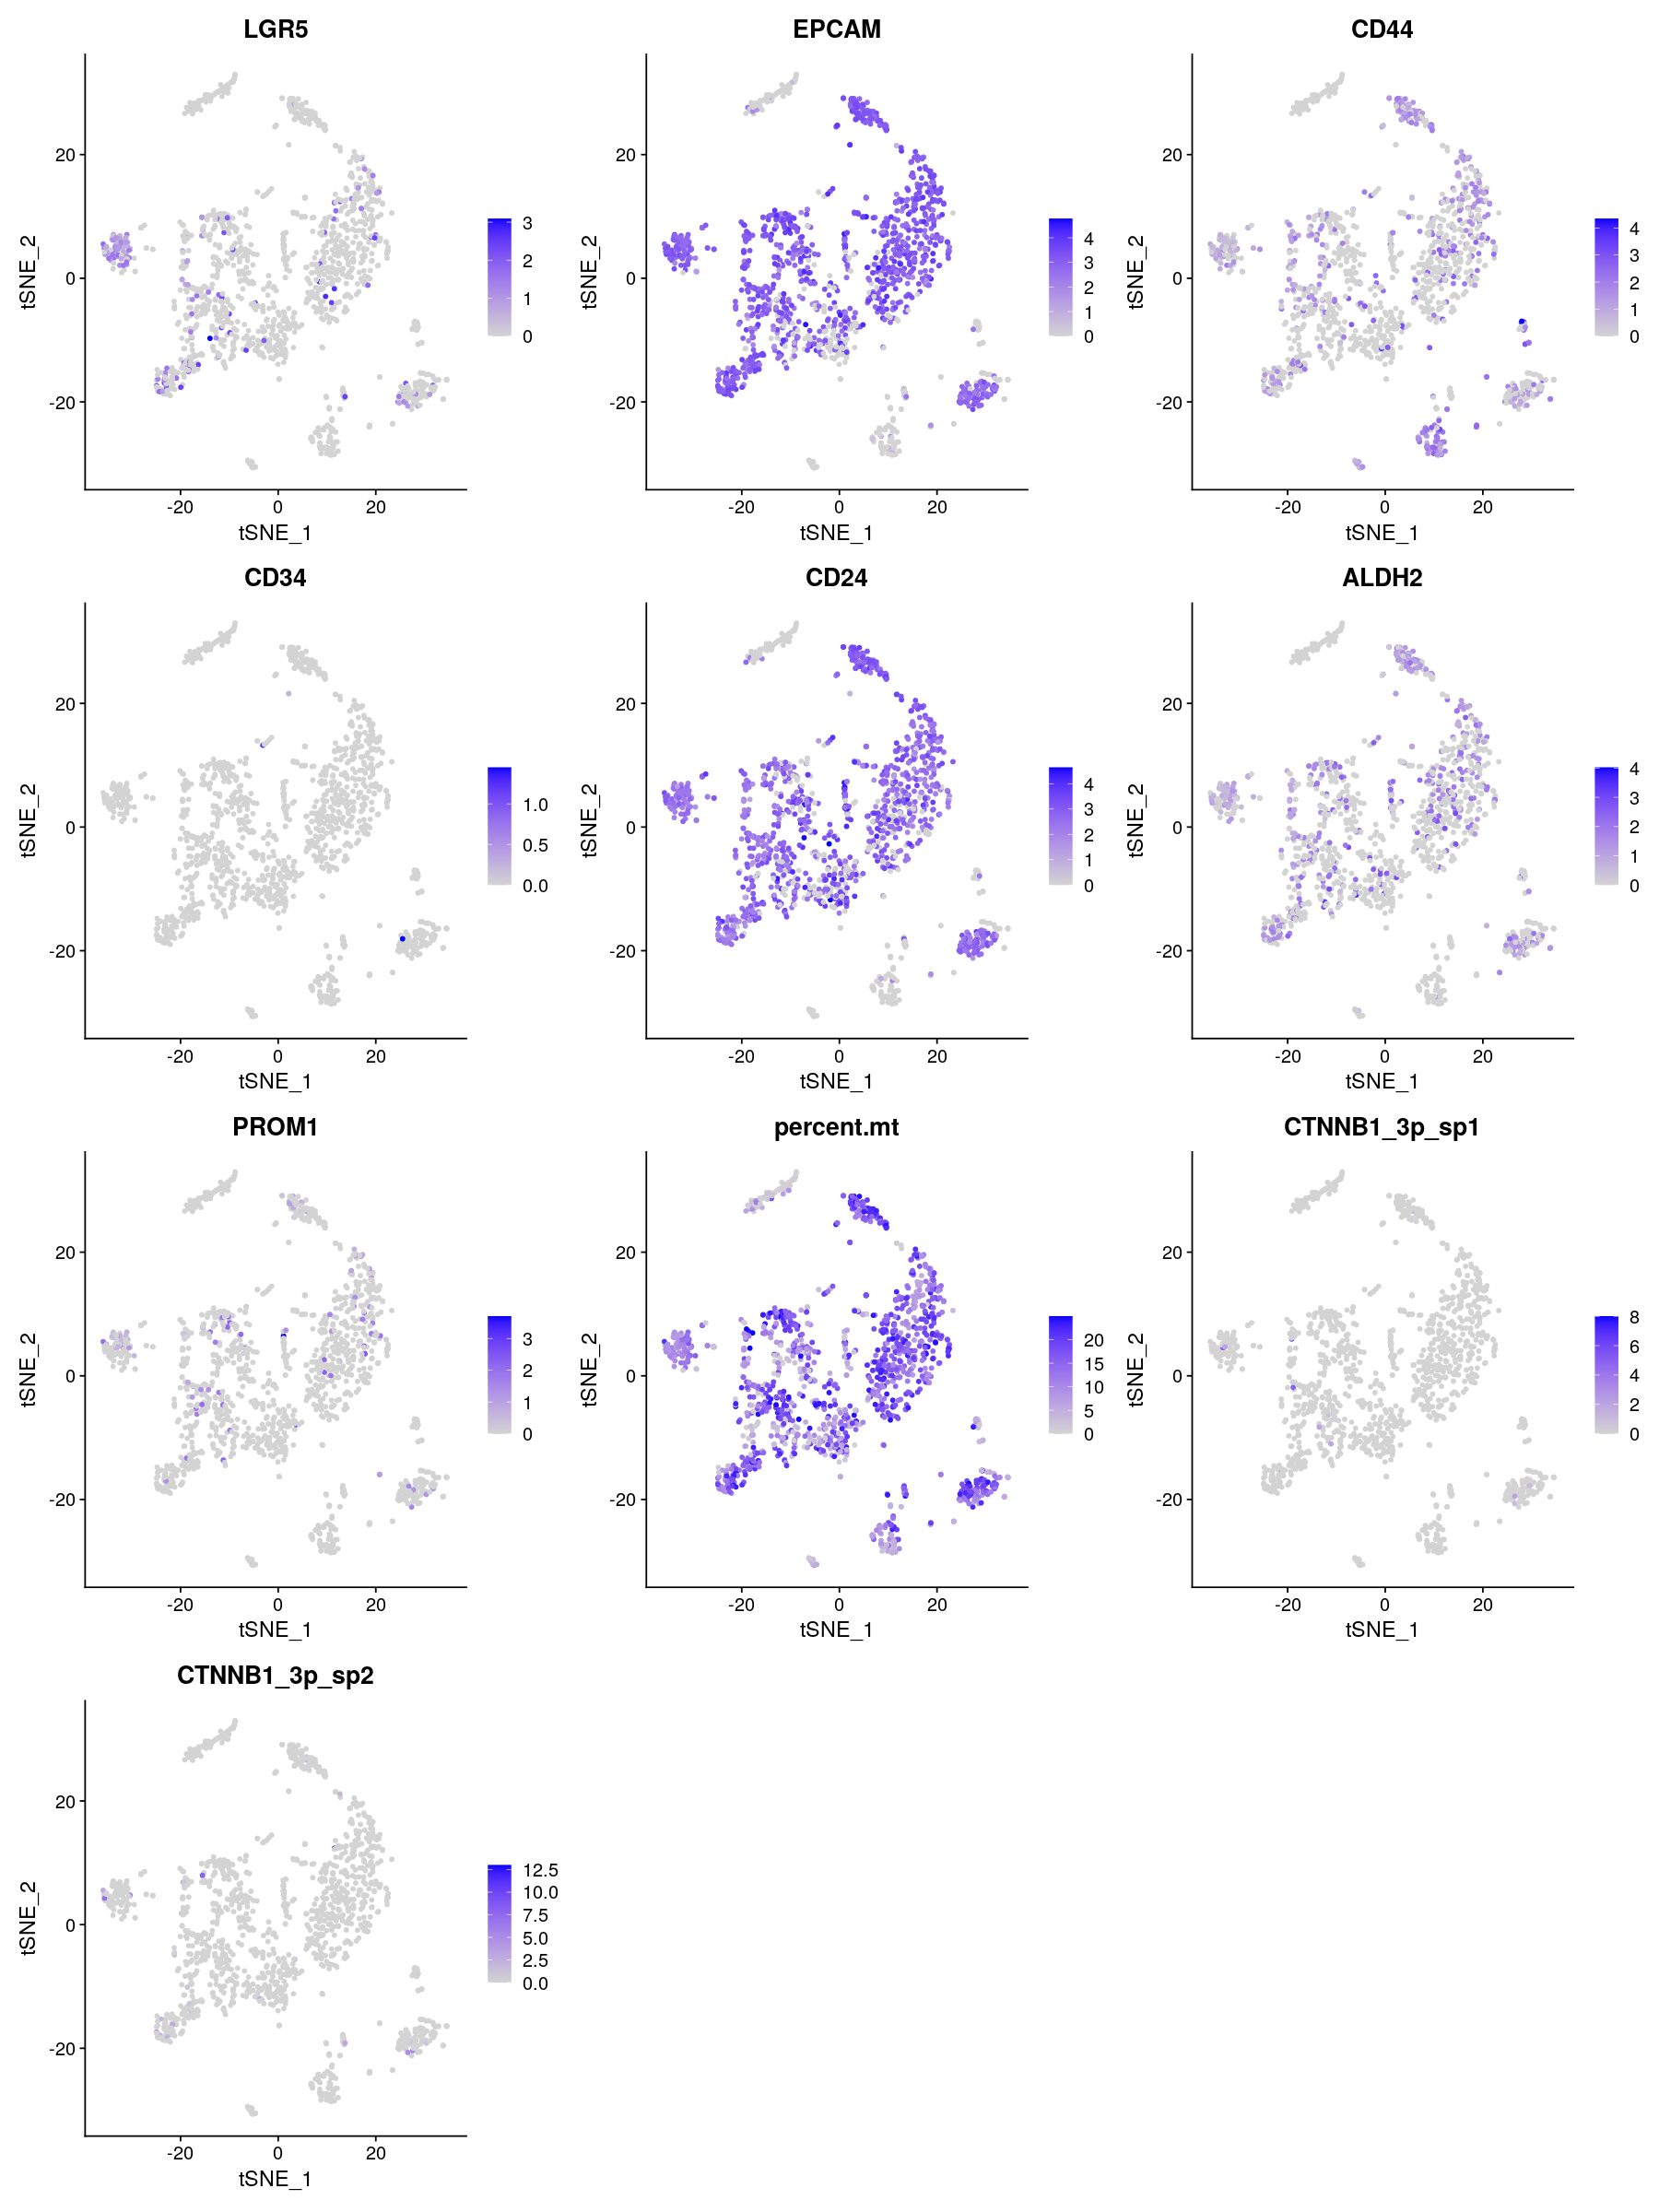

In [18]:

source("~/source/ggplot_theme.R")
features=c("LGR5","EPCAM","CD44","CD34","CD24","ALDH2","PROM1","percent.mt","CTNNB1_3p_sp1","CTNNB1_3p_sp2")
p0=DimPlot(expr_cluster, reduction = "tsne",cols=friendly_cols) + ggtitle("Cluster") +theme(aspect.ratio=1,plot.title = element_text(hjust = 0.5))
# p0$layers[[1]]$aes_params$alpha = 1
# p0$layers[[1]]$aes_params$stroke = 0
p1=DimPlot(expr_cluster, reduction = "tsne",cols=friendly_cols,group.by="library_id")+ theme(aspect.ratio=1)
# p1$layers[[1]]$aes_params$alpha = .6
# p1$layers[[1]]$aes_params$stroke = 0
# p1$layers$alpha=0.5
p2=NULL
for(i in 1:length(features)){
  p=FeaturePlot(expr_cluster, 
            features=features[i],
            reduction = "tsne"
    ) 
  if(is.null(p2)){
      p2=p
  } else{
      p2=p2+p
  }
}
options(repr.plot.width=12, repr.plot.height=8)
p0+p1
options(repr.plot.width=15, repr.plot.height=20)
(p2+plot_layout(ncol=3))

# save RDS file

In [59]:
downstream_dir=file.path(
    "/datawaha_sfb/liz0f/Long-read-RNA-seq/downstream",
    "Colon_PS017-PS033-filter-bc_seurat_reference_transform-newmut"
)
dir.create(downstream_dir)
dir.create(file.path(downstream_dir,"Seurat"), showWarnings=FALSE)
expr_save=expr_cluster
DefaultAssay(expr_save)="RNA"
expr_save=SetIdent(expr_save,cells=NULL,value="seurat_clusters")
saveRDS(expr_save,file.path(downstream_dir,"Seurat","expr.rds"))

Warning message in dir.create(downstream_dir):
“'/datawaha_sfb/liz0f/Long-read-RNA-seq/downstream/Colon_PS017-PS033-filter-bc_seurat_reference_transform-newmut' already exists”


In [4]:
downstream_dir=file.path(
    "/datawaha_sfb/liz0f/Long-read-RNA-seq/downstream",
    "Colon_PS017-PS033-filter-bc_seurat_reference_transform-newmut"
)
expr_save=readRDS(file.path(downstream_dir,"Seurat","expr.rds"))